# Google Location History 

In this notebook we will explore all the location data that google tracks from our smartphone.
As it is known, Google continuosly tracks user location. 

[It tracks location even when the setting was turned off](https://www.theverge.com/2017/11/21/16684818/google-location-tracking-cell-tower-data-android-os-firebase-privacy), as we knew in 2017.

You can use [Google Timeline](https://www.google.com/maps/timeline) to see all this data.
 ![Google Timeline](https://unmonoqueteclea.github.io/assets/images/google_timeline.png)


What some people don´t know is that we can **download all this data in a JSON file**. Google offers the [Takeout service](https://takeout.google.com/) to let the user download its personal data. One of the things that we can download from Google Takeout is our **Location History**. This is the first thing that we will do in this Jupyter notebook, because we will use the generated JSON file to create some interesting visualizations.

We should navigate to [Google Takeout site](https://takeout.google.com/) and choose to download only **Location History** data. 
Check that the chosen format is **JSON**.
 
 ![Google Takeout](https://unmonoqueteclea.github.io/assets/images/takeout_location.png)

Then, click **next**, choose one file type, and click on **Create file**. Google will email you when the file is prepared to be downloaded. After having downloaded it, we will look for the *.json* file, and rename it to **locations.json**. After this, we will copy it to our working directory.



## Dependencies
In order to run this Jupyter notebook properly, my advise is to create a new **Conda enviroment** and install the following dependencies. It´s very important that we install the **0.15 version of scikit-learn**, because in later versions there is an algorithm (DBScan) that we are using in this notebook that won´t work properly.


- conda create -n LocationHistory python=3.4 scikit-learn=0.15 matplotlib pandas jupyter
- conda install -c conda-forge folium
- conda install -c scitools shapely
- conda install -c conda-forge geopy 
- conda install -c conda-forge ipywidgets

## Sources
I have used code from these sources:

- http://beneathdata.com/how-to/visualizing-my-location-history/
- https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb

## Expected results

This notebook will generate an animated heatmap as the one of this image:

![heatmap](https://unmonoqueteclea.github.io/assets/gifs/heatmap.gif)

It will also create an interactive bar graph where you can choose month and year and it will show the most visited locations.

![locations bargraph](https://unmonoqueteclea.github.io/assets/gifs/locgraph.gif)



## Importing needed packages

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from datetime import datetime as dt
import json
from folium import Map
from folium.plugins import HeatMap,HeatMapWithTime
import time
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from IPython import display
from ipywidgets import interact, Dropdown

## Useful functions

In [2]:
def transformUnits(locations_df):
    # Convert to typical units
    locations_df.latitudeE7 = locations_df.latitudeE7/float(1e7) 
    locations_df.longitudeE7 = locations_df.longitudeE7/float(1e7)
    #Convert to seconds
    locations_df.timestampMs = locations_df.timestampMs.map(lambda x: float(x)/1000) 
    locations_df['datetime'] = locations_df.timestampMs.map(dt.fromtimestamp)
    #Rename fields based on the conversions we just did
    locations_df.rename(
        columns={'latitudeE7':'lat', 'longitudeE7':'lon', 'timestampMs':'timestamp'}, 
        inplace=True
    )
    return locations_df

In [3]:
def getLocationByMonth(df,month,year):
    # Get all locations from a month and a year
    month_df = df[ (df['datetime'].dt.month==month) & (df['datetime'].dt.year==year) ]
    return month_df

In [4]:
def coords2str(coords):
    # Transforms a pair of coordinates into a string
    convert_first_to_generator = (str(w) for w in coords)
    new_coords=','.join(convert_first_to_generator)
    return str(new_coords)

## Loading and cleaning data
Here, we will load the json file into a Pandas Data Frame. 
Then we will perfom some cleaning.

In [5]:
with open('locations.json', 'r') as fh:
    #Reading json file
    raw = json.loads(fh.read())
#Transforming into a Pandas Data Frame
locations_df = pd.DataFrame(raw['locations'])
del raw #Free up some memory
print('There are {:,} rows'.format(len(locations_df)))
#Transforming units
locations_df = transformUnits(locations_df)
#Ignore locations with accuracy estimates over 1000m
locations_df = locations_df[locations_df.accuracy < 1000] 
#Reset data frame index
locations_df.reset_index(drop=True, inplace=True)
#Sorting locations by date
locations_df.sort_values(by=['datetime'], inplace=True);

There are 950,298 rows


## Obtaining start and end dates
We will look for the oldest and the newest date in our file

In [6]:
from_day = locations_df.head(1)['datetime'].dt.day.iloc[0]
from_month = locations_df.head(1)['datetime'].dt.month.iloc[0]
from_year = locations_df.head(1)['datetime'].dt.year.iloc[0]
to_day = locations_df.tail(1)['datetime'].dt.day.iloc[0]
to_month = locations_df.tail(1)['datetime'].dt.month.iloc[0]
to_year = locations_df.tail(1)['datetime'].dt.year.iloc[0]
print("From day {} month: {} of {}".format(from_day,from_month,from_year))
print("To day {} month: {} of {}".format(to_day,to_month,to_year))

From day 26 month: 12 of 2013
To day 22 month: 11 of 2017


## Heatmap with the full dataset
In this part, we will create an **animated heatmap** with the locations of each month. We will use the full dataset, so it will generate a huge file. As we will see later, we can achieve the same results applying a clustering algorithm to our data to reduce the final file size.

### Creating data and time_info lists
We will create here two main lists:
- **data**: Each position contains all the locations from a month
- **time_info**: Each position contains the name of a month and a year.


In [7]:
start_date=dt.strptime(str(from_year)+'-'+str(from_month)+'-'+str(1), "%Y-%m-%d")
end_date =dt.strptime(str(to_year)+'-'+str(to_month)+'-'+str(to_day), "%Y-%m-%d")
data=[]
time_info=[]
while(start_date<end_date):
    current_month=start_date.month; #Obtains start month
    current_year=start_date.year; #Obtains start year
    #Get all locations from current month and year
    month = getLocationByMonth(locations_df,current_month,current_year)
    #Creating a matrix with latitudes and longitudes
    coordinates = month[['lat', 'lon']].as_matrix()
    #Transforming into a list of lists
    coordinates = [[i[0],i[1]] for i in coordinates]
    #Appending month coordinates to the data list
    data.append(coordinates)
    #Appending current month and year to the time_info list
    time_info.append(start_date.strftime("%B")+"-"+str(start_date.year))
    #Update date. Get next month
    current_month = 1 if current_month==12 else current_month+1
    current_year = current_year+1 if current_month==1 else current_year
    start_date=dt.strptime(str(current_year)+'-'+str(current_month)+'-'+str(1), "%Y-%m-%d")
    #Clear Jupyter output
    display.clear_output(wait=True)
    print("Wait...\nProcessing date {}".format(start_date))

display.clear_output(wait=True)
print("Finished processing locations")

Finished processing locations


### Creating heatmap
- The map will be centered in Madrid. **Change it to wherever you want!**.
- It will use a zoom value that lets the user see all Spain. **Change it to the value that fits your data**.
- **A very heavy file will be generated**. In my case, a 34MB html file. It will take the browser a few seconds to display it.

In [8]:
m = Map([40.4893538,-3.6827461], zoom_start=6,tiles='stamentoner')
hm = HeatMapWithTime(data,index=time_info,radius=8,max_opacity=0.9)
hm.add_to(m)
m.save("LocationsHeatMap.html")

## Heatmap with reduced dataset
Now we will use the [DBScan Clustering Algorithm](https://en.wikipedia.org/wiki/DBSCAN) to reduce the number of locations. We have to take care of our time dimension. Instead applying the algorithm to the full dataset at once, we will apply to all the coordinates of each month.

As we will see, it will reduce drastically our final file size. This code is based on [this notebook](https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb)

### Clustering functions

In [9]:
def get_centermost_point(cluster):
    # It will give us the point in each cluster that is closest to its centroid
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [10]:
def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    # It will apply DBScan algorithm
    start_time = time.time()
    # Represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df.as_matrix(columns=[y, x])   
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # Find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # Unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # Pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # All done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return (rs,clusters)

In [11]:
def reduce_dataset(dataset, remove_highways=False):
    # It will apply DBScan one or more times to achieve better results.
    
    # Define the number of kilometers in one radian
    kms_per_radian = 6371.0088
    # First cluster the full month location history data set coarsely, with epsilon=2.55km in radians
    eps_rad = 2.5 / kms_per_radian
    df_clustered = dbscan_reduce(dataset, epsilon=eps_rad)
    
    '''
    From https://github.com/gboeing/data-visualization/blob/master/location-history/google-location-history-cluster.ipynb:
    
    The previous clustering reduces dense clusters of points to a single point. 
    Because min_samples=1, no point is noise - if there was a single gps reading in the middle of nowhere, 
    it will be retained as a cluster/point. 
    If the points were too dense along a linear strip, such as a highway, 
    it will remove the entire line of points and leave just one behind, in the middle. 
    To fix this, let's thin out the data set by retaining every nth point as df_sampled. 
    Then, combine df_sampled with df_clustered, and re-cluster once again to reduce the thinned-out data set.
    The final product will retain lonely points in the middle of nowhere 
    (that would otherwise possibly be lost by merely sampling every nth point) 
    and will not strip out long linear corridors of dense points 
    (that were removed in the first clustering step).
    
    '''
    if(remove_highways):
        # If we want to remove the entire line of points in highways
        # and leave just one behind, in the middle, we don´t need to do
        # anything more
        df_final = df_clustered
    else:
        df_clustered = df_clustered[0]
        # Next, sample every nth row (where n=sample_rate) of the full gps location history data set
        sample_rate = 20
        df_sampled = dataset.iloc[range(0, len(dataset), sample_rate)]
        # Combine the clustered and sampled sets
        df_combined = pd.concat([df_clustered, df_sampled], axis=0)
        df_combined = df_combined.reset_index().drop(labels='index', axis=1)
        # Then reduce by clustering again, finely this time with epsilon=0.1km in radians
        eps_rad = 0.1 / kms_per_radian
        df_final = dbscan_reduce(df_combined, epsilon=eps_rad)[0]
        
    return df_final

### Clustering and representing each month

Now, we will apply our clustering algorithm to the locations from each month.
As previously, we will create here two main lists:
- **data**: Each position contains all the locations (after clustering) from a month
- **time_info**: Each position contains the name of a month and a year.

In [12]:
start_date=dt.strptime(str(from_year)+'-'+str(from_month)+'-'+str(1), "%Y-%m-%d")
end_date =dt.strptime(str(to_year)+'-'+str(to_month)+'-'+str(to_day), "%Y-%m-%d")
data=[]
time_info=[]
while(start_date<end_date):
    current_month=start_date.month; #Obtains start month
    current_year=start_date.year; #Obtains start year
    #Get all locations from current month and year
    month = getLocationByMonth(locations_df,current_month,current_year)
    # Reducing dataset
    month = reduce_dataset(month,remove_highways=False)
    # Creating a matrix with latitudes and longitudes
    coordinates = month[['lat', 'lon']].as_matrix()
    # Transforming into a list of lists
    coordinates = [[i[0],i[1]] for i in coordinates] 
    #Appending current month and year to the time_info list
    data.append(coordinates)
    time_info.append(start_date.strftime("%B")+"-"+str(start_date.year))
    #Update date. Get next month
    current_month = 1 if current_month==12 else current_month+1
    current_year = current_year+1 if current_month==1 else current_year
    start_date=dt.strptime(str(current_year)+'-'+str(current_month)+'-'+str(1), "%Y-%m-%d")
    #Clear Jupyter output
    display.clear_output(wait=True)
    print("Wait...\nProcessing date {}".format(start_date))

display.clear_output(wait=True)
print("Finished processing locations")

Finished processing locations


### Creating heatmap
- The map will be centered in Madrid. Change it to wherever you want.
- It will use a zoom value that lets the user see all Spain. Change it to the value that fits your data.
- **As we have reduced our dataset, the size of the file will be only some kilobytes**

In [13]:
m = Map([40.4893538,-3.6827461], zoom_start=6,tiles='stamentoner')
hm = HeatMapWithTime(data,index=time_info,radius=10,max_opacity=0.9)
hm.add_to(m)
m.save("ReducedLocationsHeatMap.html")
m

## Calculating statistics
Now we will obtain some useful information from our location history. 

We will **reverse geocode** all the locations, and will be able to see the places where we have stayed most time each month.

### Geocoding functions

In [14]:
geolocator = Nominatim()

def geocode(coords):
    # Obtain city/town/village name from some cords
    print(coords)
    location = None
    while location is None:
        try:
            location = geolocator.reverse(coords).raw
        except:
            print("Error: Trying again")
            time.sleep(2)

    address = location.get('address')
    city="Desconocido"
    if(address.get('town') is not None):
        city = address.get('town')
    elif(address.get('city') is not None):
        city = address.get('city')
    elif(address.get('village') is not None):
        city = address.get('village')
    print(city)
    return city

### Calculating monthly most visited places

In [15]:
start_date=dt.strptime(str(from_year)+'-'+str(from_month)+'-'+str(1), "%Y-%m-%d")
end_date =dt.strptime(str(to_year)+'-'+str(to_month)+'-'+str(to_day), "%Y-%m-%d")
data=[]
time_info=[]
while(start_date<end_date):
    current_month=start_date.month; #Obtains start month
    current_year=start_date.year; #Obtains start year
    #Get all locations from current month and year
    month = getLocationByMonth(locations_df,current_month,current_year)
    # Reducing dataset
    [centroids,clusters] = reduce_dataset(month,remove_highways=True) 
    # Creating a matrix with latitudes and longitudes of cluster centroids
    centroids = centroids[['lat', 'lon']].as_matrix()
    
    # Each element of visited cities contains a city name
    # and the number of loctions in the same cluster as
    # the city.
    visited_cities=[ 
        (geocode(coords2str(element)) ,len(clusters[i])) 
        for i,element in enumerate(centroids) 
        if len(clusters[i])>100
    ]
    # Appending the month data to the data list
    data.append(visited_cities)
    # Appending month and year to the time_info list
    time_info.append(start_date.strftime("%B")+"-"+str(start_date.year))

    #Update date. Get next month
    current_month = 1 if current_month==12 else current_month+1
    current_year = current_year+1 if current_month==1 else current_year
    start_date=dt.strptime(str(current_year)+'-'+str(current_month)+'-'+str(1), "%Y-%m-%d")
    
    #Clear Jupyter output
    display.clear_output(wait=True)
    print("Wait...\nProcessing date {}".format(start_date))

display.clear_output(wait=True)
print("Finished processing locations")

Finished processing locations


### Displaying them in an interactive graph
Now we will create an interactive graph where we can choose month and date and we will be able to see the places where we have spent more time this month.

<IPython.core.display.Javascript object>


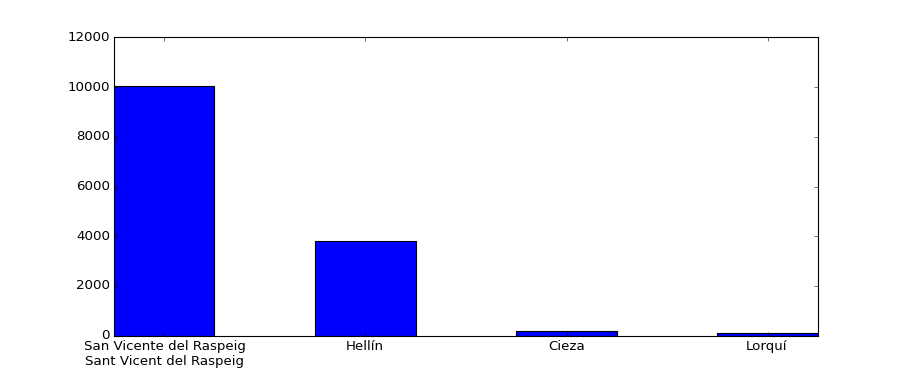

In [17]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
years=list(range(from_year,to_year+1))

# Creating the graph
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
bar_width = 0.5

def avaliableMonthsFromYear(year):
    #This function returns the months that we can choose depending on the chosen year.
    # For instance, if the oldest date from our dataset is March of 2015,
    # We can´t choose the month February if we have chosen year 2015.
    output_months = months;
    if(int(year==from_year)):
        if(from_year==to_year):
            output_months=months[from_month-1:to_month]
        else:
            output_months=months[from_month-1:]
    elif(int(year==to_year)):
        output_months=months[0:to_month]
    return output_months


def f(y,x):
    #This function will update the graph
    # y is the chosen year, and x, the chosen month
    month=months.index(x)
    year=int(y)
    #Obtaining list position from the month and year chosen
    position=(year-from_year)*12 + month-from_month +1
    ax.clear() # Clear the graph
    plt.figure(fig.number) #Active current figure
    if(position>=0 and position<len(data)):
        month_info = data[position]
        places = [item[0].replace("/","\n") for item in month_info]
        values = [item[1] for item in month_info]
        x_data = np.arange(len(places))+1
        plt.bar(x_data, values,bar_width) #Creating the new bars
        plt.xticks(x_data+bar_width/2, places) #Setting X axis data
        fig.canvas.draw()
    else:
        print("There is no information for this date")
    return fig

#Creating dropdowns
x_widget = Dropdown(
    options=avaliableMonthsFromYear(years[0]), 
    value=months[from_month-1],
    description='Month:')
y_widget = Dropdown(options=years,description='Year:')

def update_month_range(*args):
    x_widget.options = avaliableMonthsFromYear(y_widget.value)
    
#Updating months dropdown each time we choose a year
y_widget.observe(update_month_range, 'value')

interact(f, y=y_widget, x=x_widget);


### Aggregating historic data
Now we will create another bar graph to see the all-time most visited places

<IPython.core.display.Javascript object>


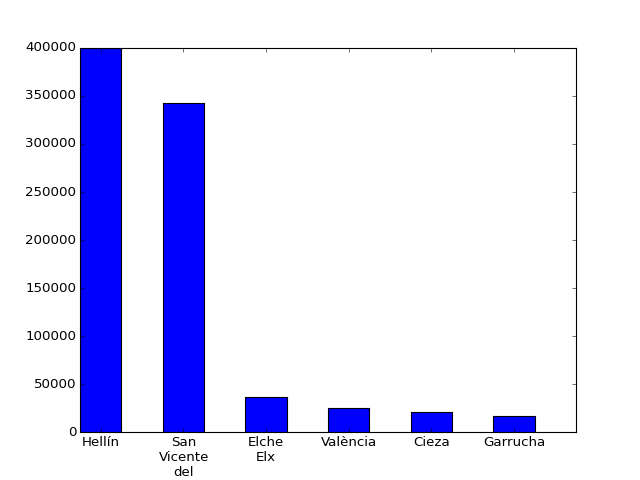

In [18]:
historic_locations = {}
for month in data: #For each month
    for location in month: #For each location
        # Add the number of appearances of the location
        # to the dictionary
        if historic_locations.get(location[0]) is None:
            historic_locations[location[0]]=location[1]
        else:
            historic_locations[location[0]]+=location[1]
#Creating the bar graph
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.show()
bar_width = 0.5
#Sorting places by number of appearances 
historic_locations = sorted(historic_locations.items(), key=lambda x: x[1],reverse=True)
places= [x.replace("/","\n").replace(" ","\n") for x,_ in historic_locations][0:6]
values= [y for _,y in historic_locations][0:6]
x_data = np.arange(len(places))+1
plt.bar(x_data, values,bar_width) #Ploting the bar
plt.xticks(x_data+bar_width/2, places)
fig2.canvas.draw()